In [ ]:
'''
Project: NGuard
Dataset: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip
'''

'\nProject: NGuard\nDataset: http://205.174.165.80/CICDataset/CIC-IDS-2017/Dataset/MachineLearningCSV.zip\n'

**Download dataset**
- download the zip
- concatenate csv file as a single csv file
- convert csv into pandas dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


import pandas as pd
import numpy as np
import glob
import pathlib
import os
from joblib import dump,load

def extract_dataset():
  file_name = pathlib.Path("*.parquet")
  if not file_name.exists ():
    import zipfile
    with zipfile.ZipFile(os.getcwd()+"/drive/MyDrive/attackdataset.zip","r") as zip_ref:
      zip_ref.extractall()

  folder_path = os.getcwd() 
  return folder_path  


def read_as_dataframe(master_file):
  file_name = pathlib.Path("*.parquet")
  if not file_name.exists ():
    df = pd.concat(master_file,ignore_index=True)
    df.to_parquet('merged.parquet',index=False)
  else:  
    df = pd.read_parquet(file_name,engine='pyarrow')
  return df


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Testing**

In [ ]:
def test_performance(clf,x_test,y_actual,attack_name):
     
    from sklearn.metrics import f1_score,confusion_matrix,ConfusionMatrixDisplay
    from sklearn.metrics import precision_recall_curve, precision_score
    from sklearn.metrics import recall_score
    from sklearn.metrics import average_precision_score
    
    y_predicted = clf.predict(x_test)
    score = f1_score(y_actual,y_predicted,average='micro')
    print('F1 Score: %.3f' % score)
    cmatrix = confusion_matrix(y_actual,y_predicted,labels=[1,0])
    cm_obj = ConfusionMatrixDisplay(cmatrix,display_labels=[1,0])
    cm_obj.plot()
    cm_obj.ax_.set(
                    title=f'{attack_name} Confusion Matrix', 
                    xlabel='Predicted Class', 
                    ylabel='True Class')



    print('Precison',precision_score(y_actual, y_predicted, average='macro'))
    print('Recall',recall_score(y_actual, y_predicted, average='macro'))
    print('Misclassification',(cmatrix[0][1]+cmatrix[1][0])/(cmatrix[0][0]+cmatrix[0][1]+cmatrix[1][0]+cmatrix[1][1]))
    print('Accuracy',(cmatrix[0][0]+cmatrix[1][1])/(cmatrix[0][0]+cmatrix[0][1]+cmatrix[1][0]+cmatrix[1][1]))
    print('FPR(A classicifed as B)',(cmatrix[1][0])/(cmatrix[1][0]+cmatrix[1][1]))
  

  

**Operations**

In [ ]:

dirpath = extract_dataset()

dos_data = pd.read_parquet(f'{dirpath}/dos.parquet',engine="pyarrow")
ddos_data = pd.read_parquet(f'{dirpath}/ddos.parquet',engine="pyarrow")
port_data =  pd.read_parquet(f'{dirpath}/portscan.parquet',engine="pyarrow")
patator_data =  pd.read_parquet(f'{dirpath}/patator.parquet',engine="pyarrow")
web_data = pd.read_parquet(f'{dirpath}/web.parquet',engine="pyarrow")



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE


dos performance metrics
F1 Score: 0.948
Precison 0.9604637062647757
Recall 0.929415143162039
Misclassification 0.05219005089560546
Accuracy 0.9478099491043945
FPR(A classicifed as B) 0.13859413821156086


portscan performance metrics
F1 Score: 1.000
Precison 0.9994857270817661
Recall 0.9994598956755945
Misclassification 0.00042254039815710364
Accuracy 0.9995774596018429
FPR(A classicifed as B) 0.0008039877793857533


ddos performance metrics
F1 Score: 1.000
Precison 0.9993300355546788
Recall 0.9993180576073193
Misclassification 0.00048759001464818743
Accuracy 0.9995124099853518
FPR(A classicifed as B) 0.0010501193317422435


patator performance metrics
F1 Score: 0.992
Precison 0.9781989884436485
Recall 0.892628656426274
Misclassification 0.007565054233664491
Accuracy 0.9924349457663355
FPR(A classicifed as B) 0.2137809187279152


web performance metrics
F1 Score: 0.994
Precison 0.6347674483847425
Recall 0.5699484333856345
Misclassification 0.005863853050196229
Accuracy 0.99413614694980

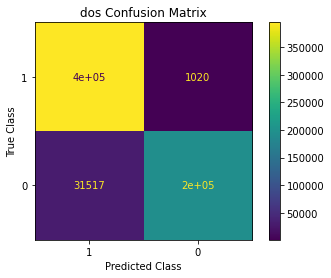

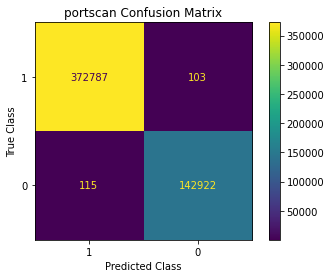

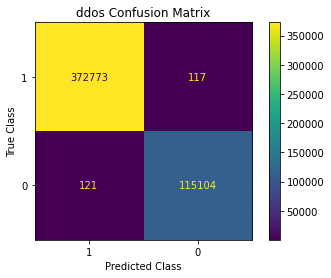

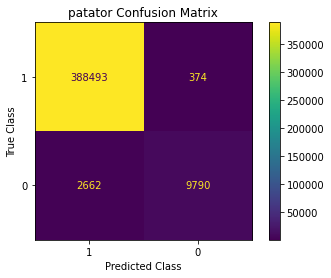

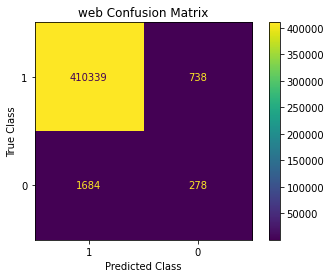

In [ ]:

data = {
    'dos':dos_data,
    'portscan':port_data,
    'ddos':ddos_data,
    'patator':patator_data,
    'web':web_data
}


for name,attack in data.items():
     
    X_train, X_test, Y_train, Y_test = train_test_split(attack.drop('Label', axis=1),
                                                          attack['Label'], stratify=attack['Label'],
                                                          train_size=0.10)


    scaler =  StandardScaler()
    X = scaler.fit_transform(X_train.values)
    pca = PCA(n_components=8)
    X = pca.fit_transform(X)
    sm =  SMOTE()
    X,Y = sm.fit_resample(X,Y_train.values.astype('int'))
    clf = RandomForestClassifier(random_state=2,n_jobs=-1)
    clf.fit(X, Y)
    print(f'{name} performance metrics')
    test_performance(clf=clf,
                    x_test=pca.transform(scaler.transform(X_test.values)),
                    y_actual=Y_test.values.astype('int'),
                    attack_name=name
                    )
    print('\n')
    dump(scaler,f'{name}scaler')
    dump(pca,f'{name}pca')
    dump(clf,f'{name}')
